In [1]:
# %%capture --no-stderr
# %pip install -U langgraph langchain langchain_openai langchain_experimental

In [1]:
import getpass
import os


## Create Tools

In [51]:
from typing import Annotated, List
from patra_agent.util import graph, llm, top_k_results
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


# Tools for Patra
@tool
def execute_cypher(
        query: Annotated[str, "Cypher query to execute on the graph"],
) -> Annotated[str, "Result of the Cypher query execution"]:
    """Execute the given cypher query on the graph."""
    response = graph.query(query)[:top_k_results]
    query_result = str(response).replace("{", "{{").replace("}", "}}")
    return query_result


@tool
def submit_job(
        image: Annotated[str, "Id of the raw image"],
        device: Annotated[str, "ID of the device"],
        model: Annotated[str, "model_id for the model"],
) -> Annotated[str, "Result of the job submission"]:
    """Execute the given cypher query on the graph."""
    result = f'Successfully submitted job for {image} in {device} and {model}'
    print(result)
    return result + "\nIf you have completed all tasks, respond with FINAL ANSWER."


## Helper Utilities

## Define Agent Teams

### Patra Team

This team will execute and return the results of cypher queries on the Patra Graph

In [52]:
from typing import List, Optional
from typing import TypedDict
import functools
import operator

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_openai.chat_models import ChatOpenAI
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph, START


def create_agent(
        llm: ChatOpenAI,
        tools: list,
        system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += "\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason! You are one of the following team members: {team_members}."
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            (
                "human",
                "Graph schema is available at {graph_schema}",
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor


def agent_node(state, agent, name):
    result = agent.invoke(state)    
    return {"messages": [HumanMessage(content=result["output"], name=name)],
            "sender": name}


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    sender_options = ["supervisor"]
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
                "sender": {
                    "title": "Current sender",
                    "anyOf": [
                        {"enum": sender_options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
            prompt
            | llm.bind_functions(functions=[function_def], function_call="route")
            | JsonOutputFunctionsParser()
    )

In [53]:
# Patra graph state
class PatraKGState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    graph_schema: str
    sender: str
    next: str

supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  QueryExecutor and JobSubmitter. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["QueryExecutor", "JobSubmitter"],
)

In [54]:
from typing import Literal
from patra_agent.cypher_templates import patra_generation_template, job_submission_template

query_executor = create_agent(
    llm,
    [execute_cypher],
    patra_generation_template
)
query_executor_node = functools.partial(agent_node, agent=query_executor, name="QueryExecutor")

job_submitter = create_agent(
    llm,
    [submit_job],
    job_submission_template,
)
job_submitter_node = functools.partial(agent_node, agent=job_submitter, name="JobSubmitter")

def collaborate(state) -> Literal["__end__", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    return "continue"

In [55]:
structured_schema = str(graph.get_structured_schema)

patra_kg = StateGraph(PatraKGState)
patra_kg.sender = "supervisor"
patra_kg.graph_schema = structured_schema

patra_kg.add_node("QueryExecutor", query_executor_node)
patra_kg.add_node("JobSubmitter", job_submitter_node)
patra_kg.add_node("supervisor", supervisor_agent)

# Define the control flow
patra_kg.add_edge("QueryExecutor", "supervisor")
# patra_kg.add_edge("JobSubmitter", "supervisor")
patra_kg.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"QueryExecutor": "QueryExecutor", "JobSubmitter": "JobSubmitter", "FINISH": END},
)
# patra_kg.add_conditional_edges(
#     "QueryExecutor",
#     lambda x: x["sender"],
#     {
#         "JobSubmitter": "JobSubmitter",
#         "supervisor": "supervisor",
#     },
# )
patra_kg.add_conditional_edges(
    "JobSubmitter",
    collaborate,
    {"continue": "QueryExecutor", "__end__": END},
)

patra_kg.add_edge(START, "supervisor")
chain = patra_kg.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


patra_chain = enter_chain | chain

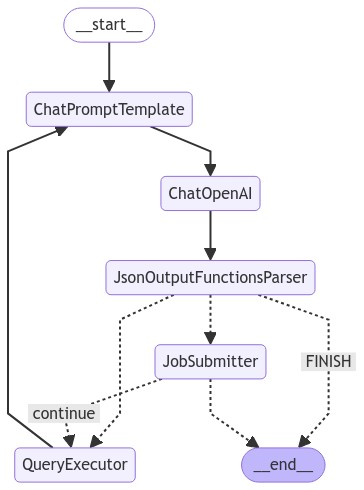

In [56]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

In [57]:
for s in patra_chain.stream(
        "Submit a job with model 323, image: x23.jpeg and device: jetson-nano", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'sender': 'supervisor', 'next': 'JobSubmitter'}}
---
Successfully submitted job for x23.jpeg in jetson-nano and 323
{'JobSubmitter': {'messages': [HumanMessage(content='FINAL ANSWER', name='JobSubmitter')], 'sender': 'JobSubmitter'}}
---


### Document Writing Team

Create the document writing team below using a similar approach. This time, we will give each agent access to different file-writing tools.

Note that we are giving file-system access to our agent here, which is not safe in all cases.

In [10]:
import operator
from pathlib import Path


# Document writing team graph state
class DocWritingState(TypedDict):
    # This tracks the team's conversation internally
    messages: Annotated[List[BaseMessage], operator.add]
    # This provides each worker with context on the others' skill sets
    team_members: str
    # This is how the supervisor tells langgraph who to work next
    next: str
    # This tracks the shared directory state
    current_files: str


# This will be run before each worker agent begins work
# It makes it so they are more aware of the current state
# of the working directory.
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
                         + "\n".join([f" - {f}" for f in written_files]),
    }


llm = ChatOpenAI(model="gpt-4-1106-preview")

doc_writer_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    "You are an expert writing a research document.\n"
    # The {current_files} value is populated automatically by the graph state
    "Below are files currently in your directory:\n{current_files}",
)
# Injects current directory working state before each call
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_agent(
    llm,
    [create_outline, read_document],
    "You are an expert senior researcher tasked with writing a paper outline and"
    " taking notes to craft a perfect paper.{current_files}",
)
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

chart_generating_agent = create_agent(
    llm,
    [read_document, python_repl],
    "You are a data viz expert tasked with generating charts for a research project."
    "{current_files}",
)
context_aware_chart_generating_agent = prelude | chart_generating_agent
chart_generating_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="ChartGenerator"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)

With the objects themselves created, we can form the graph.

In [11]:
# Create the graph here:
# Note that we have unrolled the loop for the sake of this doc
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("ChartGenerator", chart_generating_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

# Add the edges that always occur
authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("ChartGenerator", "supervisor")

# Add the edges where routing applies
authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "ChartGenerator": "ChartGenerator",
        "FINISH": END,
    },
)

authoring_graph.add_edge(START, "supervisor")
chain = authoring_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results


# We reuse the enter/exit functions to wrap the graph
authoring_chain = (
        functools.partial(enter_chain, members=authoring_graph.nodes)
        | authoring_graph.compile()
)

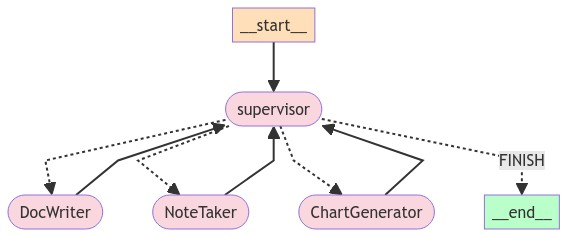

In [19]:
from IPython.display import Image, display

display(Image(chain.get_graph().draw_mermaid_png()))

In [13]:
for s in authoring_chain.stream(
        "Write an outline for poem and then write the poem to disk.",
        {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

## Add Layers

In this design, we are enforcing a top-down planning policy. We've created two graphs already, but we have to decide how to route work between the two.

We'll create a _third_ graph to orchestrate the previous two, and add some connectors to define how this top-level state is shared between the different graphs.

In [14]:
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4-1106-preview")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["ResearchTeam", "PaperWritingTeam"],
)

In [15]:
# Top-level graph state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str


def get_last_message(state: State) -> str:
    return state["messages"][-1].content


def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}


# Define the graph.
super_graph = StateGraph(State)
# First add the nodes, which will do the work
super_graph.add_node("ResearchTeam", get_last_message | research_chain | join_graph)
super_graph.add_node(
    "PaperWritingTeam", get_last_message | authoring_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

# Define the graph connections, which controls how the logic
# propagates through the program
super_graph.add_edge("ResearchTeam", "supervisor")
super_graph.add_edge("PaperWritingTeam", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "PaperWritingTeam": "PaperWritingTeam",
        "ResearchTeam": "ResearchTeam",
        "FINISH": END,
    },
)
super_graph.add_edge(START, "supervisor")
super_graph = super_graph.compile()

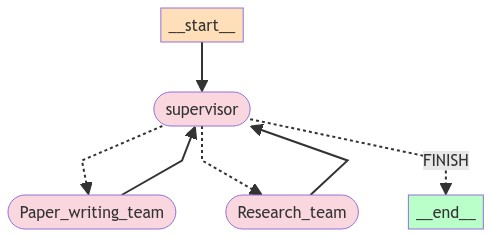

In [20]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [ ]:
for s in super_graph.stream(
        {
            "messages": [
                HumanMessage(
                    content="Write a brief research report on the North American sturgeon. Include a chart."
                )
            ],
        },
        {"recursion_limit": 150},
):
    if "__end__" not in s:
        print(s)
        print("---")